In [ ]:
# !pip install torch torchvision
# !pip install opencv-contrib-python

In [1]:
import os

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import models
from torchvision import transforms, datasets

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

In [4]:
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt

In [5]:
torch.manual_seed(64)

In [6]:
home_path = "/content/drive/MyDrive/AllTalentZ"

In [7]:
os.makedirs(f"{home_path}/models/train", exist_ok=True)

In [8]:
# dir(models)

In [9]:
# help(models.resnet152)

In [10]:
pretrained_model = models.resnet50(weights='IMAGENET1K_V2')# pretrained=True,
num_ftrs = pretrained_model.fc.in_features

# pretrained_model = models.vgg19(weights='IMAGENET1K_V1') #pretrained=True,
# num_ftrs = pretrained_model.classifier[0].in_features
num_ftrs

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]


2048

In [11]:
data_path = "/content/drive/MyDrive/AllTalentZ/data/Chess"
tmp_path = "/content/drive/MyDrive/AllTalentZ/data/Chess/train"

In [12]:
new_num_classes = len(os.listdir(tmp_path))
new_num_classes

6

In [13]:
# Training Config
num_epochs = 150
batch_size = 32 #64
num_workers = 2

In [14]:
# # Freeze all the layers of the pre-trained model

for name, param in pretrained_model.named_parameters():
  if "fc" in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

# for name, param in pretrained_model.named_parameters():
#   if "classifier" in name:
#     param.requires_grad = True
#   else:
#     param.requires_grad = False

In [15]:
# Additional linear layer and dropout layer
# pretrained_model.fc
# pretrained_model.fc = nn.Sequential(
#     nn.Linear(num_ftrs, 512),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.3),
#     nn.Linear(512, 256),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.3),
#     nn.Linear(256, 128),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.3),
#     nn.Linear(128, new_num_classes)
# )

pretrained_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, new_num_classes)
)
# pretrained_model.fc = nn.Linear(num_ftrs, new_num_classes)

In [16]:
# pretrained_model.classifier = nn.Sequential(
#     nn.Linear(num_ftrs, 512),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.3),
#     nn.Linear(512, new_num_classes)
# )

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
# # Define your optimizer with weight decay
# optimizer = optim.SGD(pretrained_model.parameters(), lr=0.003, momentum=0.9, weight_decay=0.001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)

In [28]:
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.003, weight_decay=0.0001)

In [29]:
# Define the loss function - For classification problem
loss_function = nn.CrossEntropyLoss()

In [30]:
IMAGE_SIZE = 224
data_transforms = {
    "train":transforms.Compose([
              transforms.RandomResizedCrop(size=(224,224)),
              transforms.RandomRotation(30),
              transforms.RandomHorizontalFlip(p=1),
              transforms.RandomVerticalFlip(p=1),
              # transforms.ColorJitter(brightness=(0.1, 0.3), contrast=(0.1, 0.3), saturation=(0.1, 0.3), hue=(0.1, 0.3)),
              transforms.RandomAffine(degrees=(30, 70), translate=(0.0, 0.1), scale=(0.5, 0.7)),
              transforms.ToTensor(),
              transforms.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]
          )]),
    "val": transforms.Compose([
              transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
              transforms.ToTensor(),
              transforms.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]
          )])
}


In [31]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x), data_transforms[x]) for x in ['train', 'val']}

In [32]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=num_workers) for x in ['train', 'val']}
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7c2a756de8f0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7c2a756dc490>}

In [33]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
dataset_sizes

{'train': 451, 'val': 54}

In [34]:
class_names = image_datasets['train'].classes
class_names

['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']

In [35]:
train_losses = []  # To store the losses for plotting
val_losses = []  # To store the losses for plotting
best_val_loss = float('inf')  # Initialize with a very large value
best_val_acc = 0
use_val_acc = True

In [36]:
# Train the model
for epoch in range(num_epochs):

    # Train the model on the training set
    pretrained_model.train()
    # Initialize the training loss accumulator to zero
    training_loss = 0.0

    for i, (image, labels) in enumerate(dataloaders["train"]):
        # Prepare data and send it to the proper device
        image = image.to(device)
        labels = labels.to(device)

        # Clear the gradients of all optimized parameters
        optimizer.zero_grad()

        # Forward pass: obtain model predictions for the input data
        outputs = pretrained_model(image)
        loss = loss_function(outputs, labels)

        # Backward pass: compute gradients of the loss with respect to model parameters
        loss.backward()

        # Update model parameters using the computed gradients and the optimizer
        optimizer.step()

        # Update the training loss
        training_loss += loss.item() * image.size(0)

    # Calculate average training loss
    train_loss = training_loss / dataset_sizes["train"]
    train_losses.append(train_loss)
    # scheduler.step()

    # Evaluate the model on the validation set
    pretrained_model.eval()
    val_loss = 0.0
    correct_preds = 0
    total_samples = 0
    all_labels = []
    all_pred = []
    with torch.no_grad():
        for image, labels in dataloaders["val"]:
            # Prepare data and send it to the proper device
            image = image.to(device)
            labels = labels.to(device)

            # Forward pass: obtain model predictions for the input data
            outputs = pretrained_model(image)
            _, predicted = torch.max(outputs, 1)

            # Compute the loss between the model predictions and the true labels
            loss = loss_function(outputs, labels)

            # Update the validation loss
            val_loss += loss.item() * image.size(0)

            # Round up and down to either 1 or 0
            total_samples += labels.size(0)
            # Calculate how many images were correctly classified
            predicted =  predicted.view(1, -1)
            labels = labels.view(1, -1)
            correct_preds += torch.sum(torch.eq(predicted, labels), dim=1).item()

            all_labels.extend(labels.cpu().numpy())
            all_pred.extend(predicted.cpu().numpy())

    # Calculate validation loss
    val_loss /= dataset_sizes["val"]
    val_losses.append(val_loss) # To store the losses for plotting

    # Calculate validation accuracy
    val_acc = correct_preds / total_samples #* 100

    # Print validation loss and accuracy
    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f}  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Save the model if it performs better on validation set

    if use_val_acc:
      if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(pretrained_model.state_dict(), f'/content/drive/MyDrive/AllTalentZ/models/train/best_model_epoch_{epoch + 1}--val_acc_{best_val_acc:.2f}.pth')
    else:
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(pretrained_model.state_dict(), f'/content/drive/MyDrive/AllTalentZ/models/train/best_model_epoch_{epoch + 1}--val_loss_{best_val_loss:.4f}.pth')

print('Finished Training')

Epoch [1/150] Train Loss: 2.2905  Validation Loss: 1.7773, Validation Accuracy: 0.22%
Epoch [2/150] Train Loss: 1.7934  Validation Loss: 1.6852, Validation Accuracy: 0.37%
Epoch [3/150] Train Loss: 1.6902  Validation Loss: 1.6623, Validation Accuracy: 0.46%
Epoch [4/150] Train Loss: 1.7068  Validation Loss: 1.7317, Validation Accuracy: 0.26%
Epoch [5/150] Train Loss: 1.6426  Validation Loss: 1.6945, Validation Accuracy: 0.30%
Epoch [6/150] Train Loss: 1.6570  Validation Loss: 1.6362, Validation Accuracy: 0.30%
Epoch [7/150] Train Loss: 1.6403  Validation Loss: 1.6273, Validation Accuracy: 0.35%
Epoch [8/150] Train Loss: 1.6429  Validation Loss: 1.7391, Validation Accuracy: 0.35%
Epoch [9/150] Train Loss: 1.6043  Validation Loss: 1.8207, Validation Accuracy: 0.30%
Epoch [10/150] Train Loss: 1.5997  Validation Loss: 1.6683, Validation Accuracy: 0.31%
Epoch [11/150] Train Loss: 1.6199  Validation Loss: 1.6369, Validation Accuracy: 0.37%
Epoch [12/150] Train Loss: 1.5627  Validation Loss: 

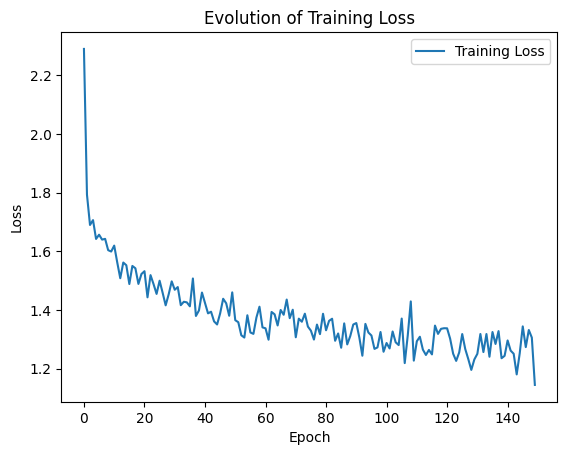

In [37]:
# Plotting the evolution of loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution of Training Loss')
plt.legend()
plt.show()

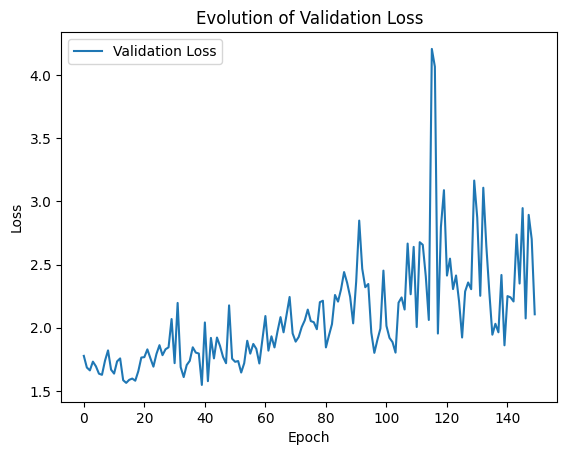

In [38]:
# Plotting the evolution of loss
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution of Validation Loss')
plt.legend()
plt.show()